# Fine-tunning DEIT TINY for covid images

## 1. Importing libraries and device

In [1]:
!pip install --quiet torchvision

# System utilities
import os
import time
import zipfile

# Numerical processing and image handling
import numpy as np
import cv2

# PyTorch and related modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Computer vision with TorchVision
import torchvision
from torchvision import models, transforms, datasets
import torchvision.transforms as T

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score



We set the device to GPU because fine-tuning Deit on covidqd images requires intensive computations, and leveraging GPU acceleration significantly speeds up the training process.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## 2. Loading and preprocessing the data from covidqu

In [3]:
## Loading the data

!pip install kaggle
!kaggle datasets download -d anasmohammedtahir/covidqu
with zipfile.ZipFile('covidqu.zip', 'r') as zip_ref:
    zip_ref.extractall('covidqu')

Dataset URL: https://www.kaggle.com/datasets/anasmohammedtahir/covidqu
License(s): CC-BY-SA-4.0
covidqu.zip: Skipping, found more recently modified local copy (use --force to force download)


### 2.1 Scanning the structure of the dataset

In [4]:
## This cell prints the structure of the dataset loaded from Kaggle

def print_directory_tree_dirs(root, indent=""):
    print(indent + os.path.basename(root) + "/")
    # On ne parcourt que les sous-dossiers
    for item in sorted(os.listdir(root)):
        path = os.path.join(root, item)
        if os.path.isdir(path):
            print_directory_tree_dirs(path, indent + "    ")


dataset_root = "/content/covidqu"
print_directory_tree_dirs(dataset_root)


covidqu/
    Infection Segmentation Data/
        Infection Segmentation Data/
            Test/
                COVID-19/
                    images/
                    infection masks/
                    lung masks/
                Non-COVID/
                    images/
                    infection masks/
                    lung masks/
                Normal/
                    images/
                    infection masks/
                    lung masks/
            Train/
                COVID-19/
                    images/
                    infection masks/
                    lung masks/
                Non-COVID/
                    images/
                    infection masks/
                    lung masks/
                Normal/
                    images/
                    infection masks/
                    lung masks/
            Val/
                COVID-19/
                    images/
                    infection masks/
                    lung masks/
        

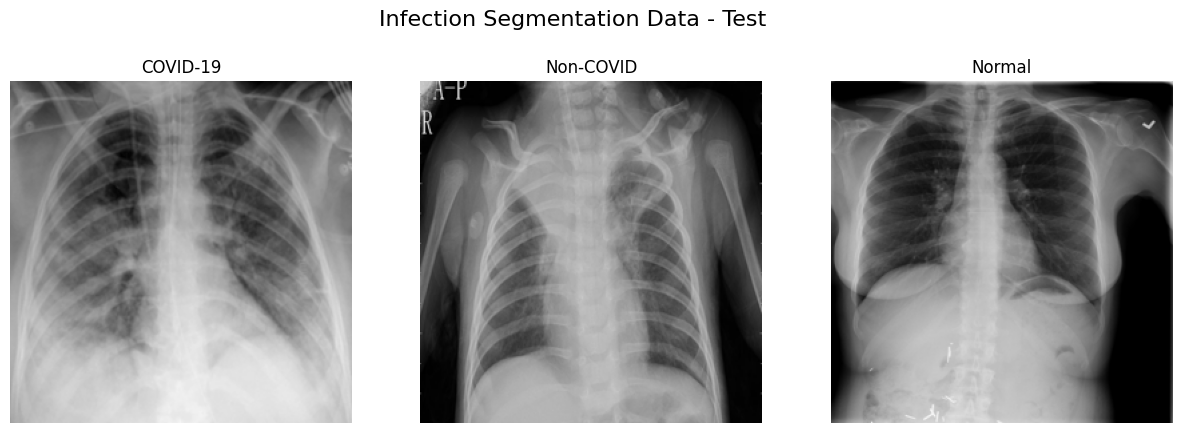

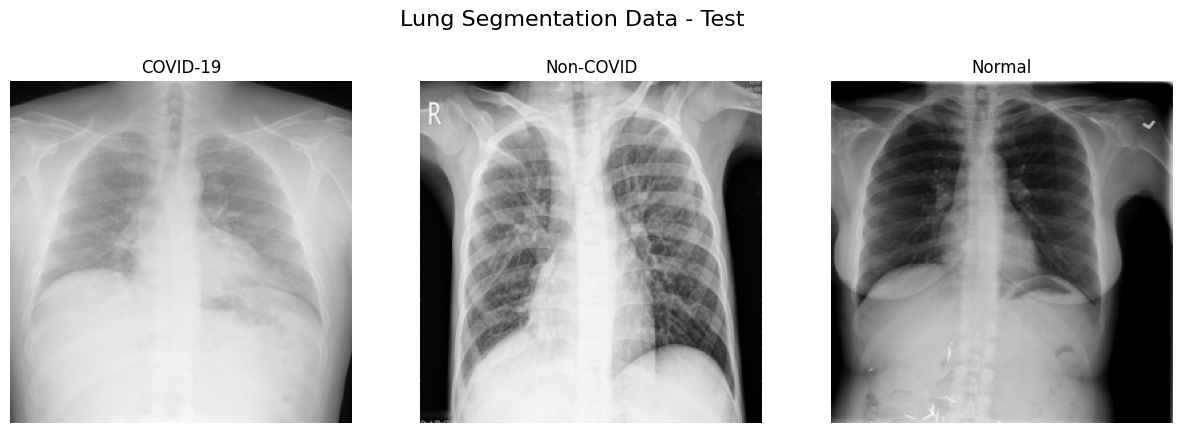

In [5]:
## This cell prints one image of each type from the dataset

def display_samples(root, segmentation_type, mode):
    """
    Affiche la première image de chaque catégorie pour le split donné.

    Args:
        root (str): Chemin racine du dataset (ex: "/content/covidqu")
        segmentation_type (str): "Infection Segmentation Data" ou "Lung Segmentation Data"
        mode (str): "Train", "Val" ou "Test" (avec la première lettre en majuscule)
    """
    # Chemin vers le dossier du split, par exemple :
    # /content/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test
    split_dir = os.path.join(root, segmentation_type, segmentation_type, mode)
    # Liste des classes (Normal, COVID-19, Non-COVID)
    classes = sorted(os.listdir(split_dir))

    # Préparation de l'affichage
    plt.figure(figsize=(15,5))
    for i, cls in enumerate(classes):
        cls_path = os.path.join(split_dir, cls, "images")
        if not os.path.isdir(cls_path):
            continue
        # Récupère la première image (selon l'ordre alphabétique)
        img_files = sorted(os.listdir(cls_path))
        if len(img_files) == 0:
            continue
        img_path = os.path.join(cls_path, img_files[0])
        # Chargement et conversion de l'image (BGR -> RGB)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Affichage de l'image
        plt.subplot(1, len(classes), i+1)
        plt.imshow(img)
        plt.title(f"{cls}")
        plt.axis("off")
    plt.suptitle(f"{segmentation_type} - {mode}", fontsize=16)
    plt.show()


display_samples(dataset_root, "Infection Segmentation Data", "Test")
display_samples(dataset_root, "Lung Segmentation Data", "Test")


### 2.2 Constructing datasets and dataloads with labels

Here we define a custom PyTorch dataset class that loads and transforms images from the covidqu dataset (specifically selecting "COVID-19" and "Normal" classes), and then creates DataLoaders for training, validation, and testing with a batch size of 64 to facilitate model training and evaluation.

COVID -> label = 1;
Normal -> label = 0.

In [6]:
## Class to generate datasets

class InfectionBinaryDataset(Dataset):
    def __init__(self, rootpath, mode='Train', cropsize=(224,224)):
        """
        Args:
            rootpath (str): Chemin vers le dossier racine du dataset (ex: "/content/covidqu")
            mode (str): "Train", "Val" ou "Test"
            cropsize (tuple): taille de redimensionnement des images, ici (224,224)
        """
        self.rootpath = rootpath
        self.mode = mode  # "Train", "Val" ou "Test"
        self.cropsize = cropsize
        self.split_dir = os.path.join(self.rootpath,
                                      "Lung Segmentation Data",
                                      "Lung Segmentation Data",
                                      self.mode)

        self.classes_to_use = ["COVID-19", "Normal"]
        self.label_map = {"COVID-19": 1, "Normal": 0}


        self.samples = []
        for cls in self.classes_to_use:
            cls_img_dir = os.path.join(self.split_dir, cls, "images")
            if not os.path.isdir(cls_img_dir):
                continue

            img_files = sorted([f for f in os.listdir(cls_img_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])

            for img in img_files:
                self.samples.append((os.path.join(cls_img_dir, img), self.label_map[cls]))

        # Here we make sure we shuffle the order of the images
        import random
        random.shuffle(self.samples)

        # Transformation
        self.transform = T.Compose([
            T.ToPILImage(),
            T.Resize(self.cropsize),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transform(img)
        label = torch.tensor(label, dtype=torch.long)
        return img, label



In [7]:
## Instancing the class to create datasets and dataloaders

dataset_root = "/content/covidqu"

data_train = InfectionBinaryDataset(rootpath=dataset_root, mode="Train", cropsize=(224,224))
data_val   = InfectionBinaryDataset(rootpath=dataset_root, mode="Val",   cropsize=(224,224))
data_test  = InfectionBinaryDataset(rootpath=dataset_root, mode="Test",  cropsize=(224,224))

batch_size = 64

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(data_val,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(data_test,  batch_size=batch_size, shuffle=False)


### 2.3 Checking the images and dimensions

In [8]:
## Checking the dimensions of the dataset

for imgs, labels in train_loader:
    print("Forme des images:", imgs.shape)
    print()
    print("Labels:", labels)
    break

print()
print()

print("Train set size:", len(data_train))
print("Validation set size:", len(data_val))
print("Test set size:", len(data_test))
print()
print("Size of the images in the training test", data_train[0][0].shape)
print("Size of the images in the validation test", data_val[0][0].shape)
print("Size of the images in the testing test", data_test[0][0].shape)

print()

print("Number of mini-batches in the training loader:", len(train_loader))
print("Number of mini-batches in the validation loader:", len(val_loader))
print("Number of mini-batches in the testing loader:", len(test_loader))

Forme des images: torch.Size([64, 3, 224, 224])

Labels: tensor([0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0])


Train set size: 14507
Validation set size: 3615
Test set size: 4535

Size of the images in the training test torch.Size([3, 224, 224])
Size of the images in the validation test torch.Size([3, 224, 224])
Size of the images in the testing test torch.Size([3, 224, 224])

Number of mini-batches in the training loader: 227
Number of mini-batches in the validation loader: 57
Number of mini-batches in the testing loader: 71


We now want to print some images with their labels to check graphically the datasets.


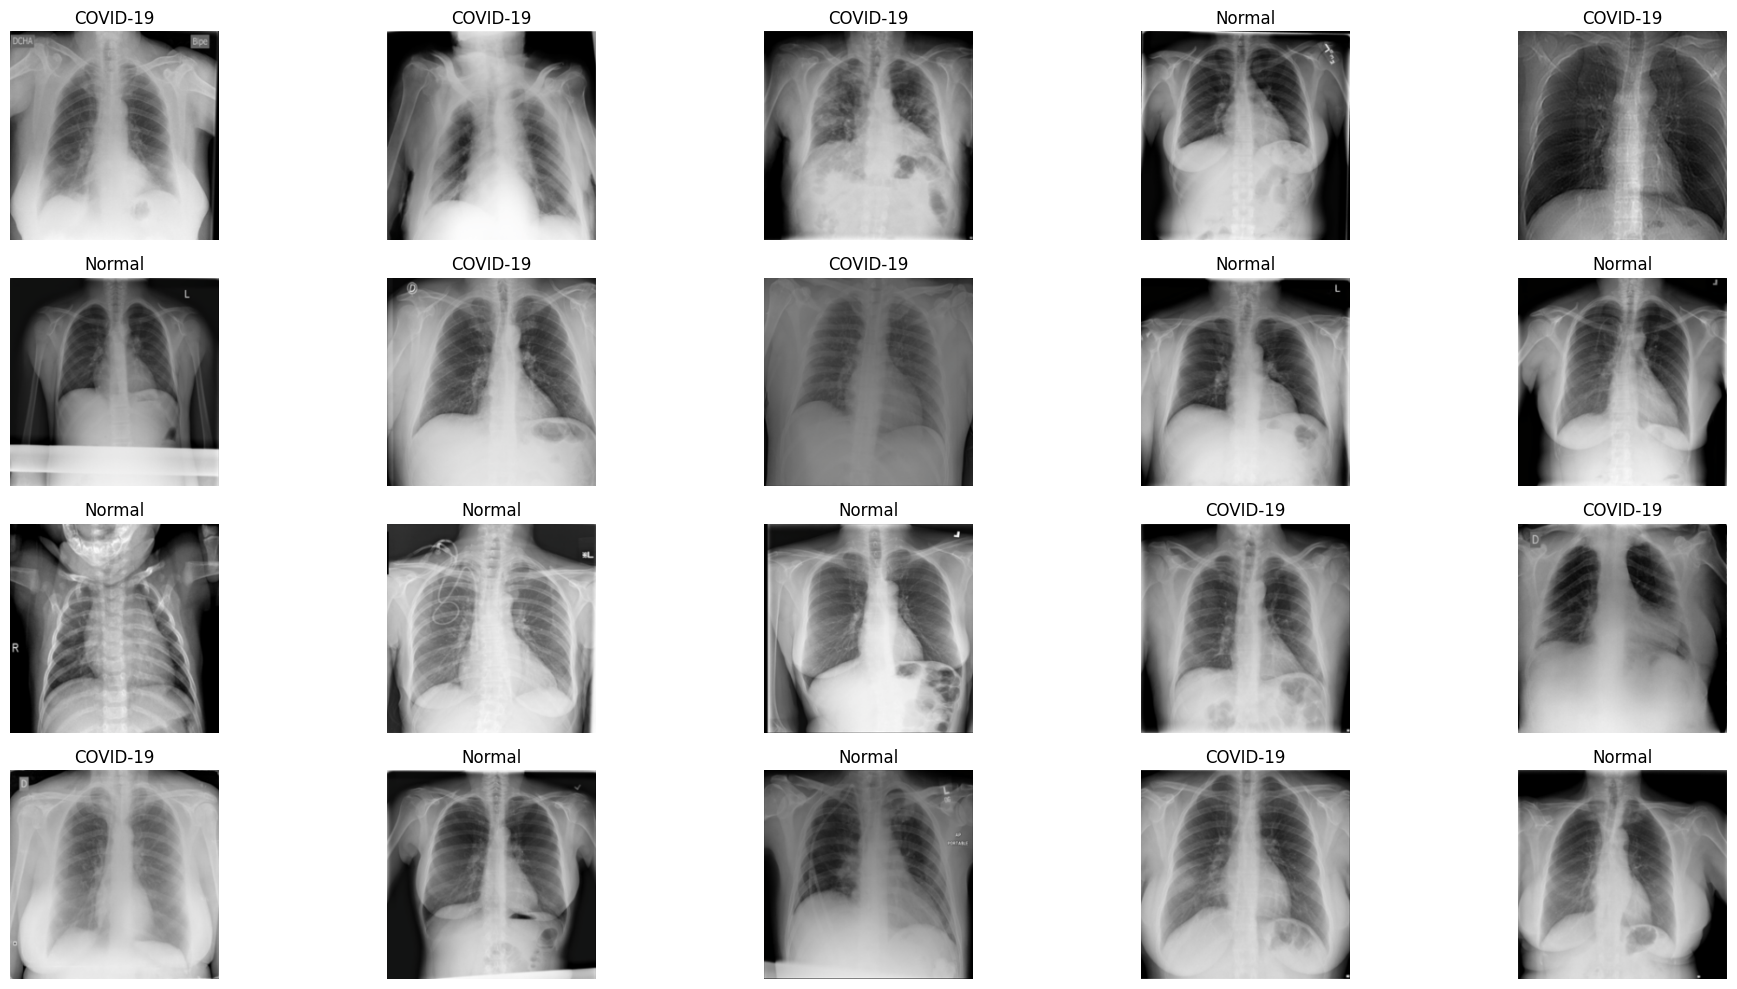

In [9]:
'''This code defines a function to reverse the normalization applied to the images and then displays 20 images from the training dataset. For each image, it applies the inverse normalization, converts the tensor to a NumPy array with the channel order (height, width, channels), and then plots the image in a grid with a title indicating if it's labeled as "COVID-19" or "Normal".
'''

def unnormalize(img):
    inv_normalize = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    return inv_normalize(img)


## Printing images
n_images = 20
plt.figure(figsize=(20, 10))

for i in range(n_images):
    img, label = data_train[i]
    img = unnormalize(img)
    img_np = img.permute(1, 2, 0).numpy()
    plt.subplot(4, 5, i+1)
    plt.imshow(img_np)
    plt.title("COVID-19" if label.item() == 1 else "Normal")
    plt.axis("off")

plt.tight_layout()
plt.show()


## 3. Fine-tunning the Deit tiny model

In [10]:
model_deit = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

# Changing the last layer to have 2 classes
in_features = model_deit.head.in_features
model_deit.head = nn.Linear(in_features, 2)


Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:62: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  @register_model
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:77: UserWarning: Overwriting deit_sm

### Generating dataloads for the head of deit tiny

We will only train the final layer of the model and evaluate the scores obtained on these data. To speed up computation, we will precompute the outputs of the frozen layers using a precompute function, thereby avoiding recalculating them every time.

In [11]:
## Defining the precompute features

def precompute_deit_tiny_features(model, dataloader):
    model.eval()
    model.to(device)
    list_outputs = []
    list_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            features = model.forward_features(inputs)
            list_outputs.append(features)
            list_labels.append(labels)

    outputs = torch.cat(list_outputs, dim=0)
    labels = torch.cat(list_labels, dim=0)

    return TensorDataset(outputs, labels)


In [12]:
## Constructing dataloaders of precomputed features

precomputed_train_dataset = precompute_deit_tiny_features(model_deit, train_loader)
precomputed_val_dataset = precompute_deit_tiny_features(model_deit, val_loader)
precomputed_test_dataset = precompute_deit_tiny_features(model_deit, test_loader)

precomputed_train_loader = DataLoader(precomputed_train_dataset, batch_size=batch_size, shuffle=True)
precomputed_val_loader = DataLoader(precomputed_val_dataset, batch_size=batch_size, shuffle=True)
precomputed_test_loader = DataLoader(precomputed_test_dataset, batch_size=batch_size, shuffle=False)

features, labels = precomputed_train_dataset[:1]  # Vérifier les 5 premiers
print(f"Taille d'un sample feature : {features.shape}")
print(f"Taille d'un sample label : {labels.shape}")


Taille d'un sample feature : torch.Size([1, 197, 192])
Taille d'un sample label : torch.Size([1])


The output before the head has a shape of (batch, 197, 192) because the transformer outputs a sequence of tokens. In this case, 197 tokens consist of 1 [CLS] token (used for classification) plus 196 patch tokens. To obtain a final representation of shape (batch, 192), we  extract the first token (the [CLS] token) from this sequence, as it aggregates the information needed for classification.

### Training and testing the model

We have to freeze all parameters of the Deit tiny model so that only the parameters of the final classification head remain trainable.

In [13]:
## Freezing features parameters

for param in model_deit.parameters():
    param.requires_grad = False
for param in model_deit.head.parameters():
    param.requires_grad = True


This cell trains only the final classification head of our model using precomputed features, evaluates the performance on validation and test sets, and then visualizes the results using a confusion matrix, classification report, and loss/accuracy curves.

Epoch 1/20 | Train Loss: 0.3802 | Train Acc: 82.87% | Val Loss: 0.2976 | Val Acc: 87.58% | Val F1: 0.8762
Epoch 2/20 | Train Loss: 0.2671 | Train Acc: 89.18% | Val Loss: 0.2584 | Val Acc: 89.41% | Val F1: 0.8954
Epoch 3/20 | Train Loss: 0.2444 | Train Acc: 89.87% | Val Loss: 0.2395 | Val Acc: 89.99% | Val F1: 0.9025
Epoch 4/20 | Train Loss: 0.2339 | Train Acc: 90.61% | Val Loss: 0.2317 | Val Acc: 90.29% | Val F1: 0.9054
Epoch 5/20 | Train Loss: 0.2263 | Train Acc: 90.91% | Val Loss: 0.2501 | Val Acc: 89.54% | Val F1: 0.8942
Epoch 6/20 | Train Loss: 0.2205 | Train Acc: 91.13% | Val Loss: 0.2296 | Val Acc: 90.43% | Val F1: 0.9058
Epoch 7/20 | Train Loss: 0.2165 | Train Acc: 91.56% | Val Loss: 0.2316 | Val Acc: 90.12% | Val F1: 0.9018
Epoch 8/20 | Train Loss: 0.2171 | Train Acc: 91.30% | Val Loss: 0.2219 | Val Acc: 91.23% | Val F1: 0.9141
Epoch 9/20 | Train Loss: 0.2131 | Train Acc: 91.46% | Val Loss: 0.2183 | Val Acc: 91.18% | Val F1: 0.9146
Epoch 10/20 | Train Loss: 0.2110 | Train Acc: 

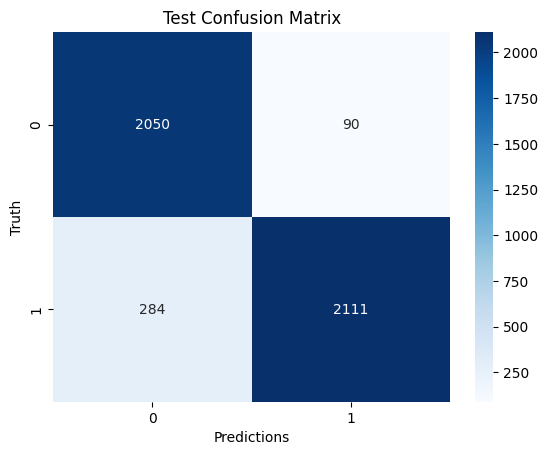

Classification report on the test set:


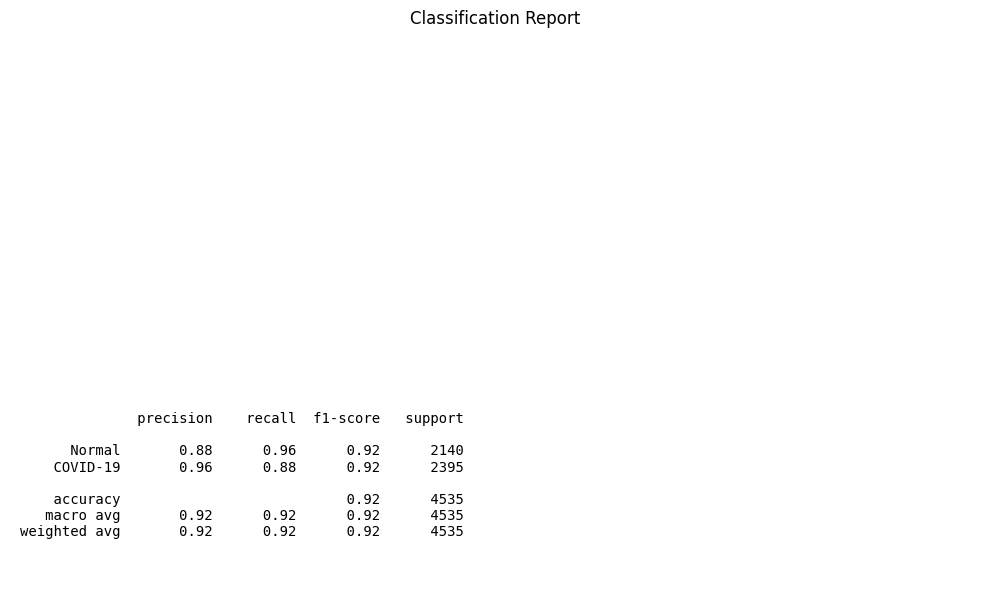

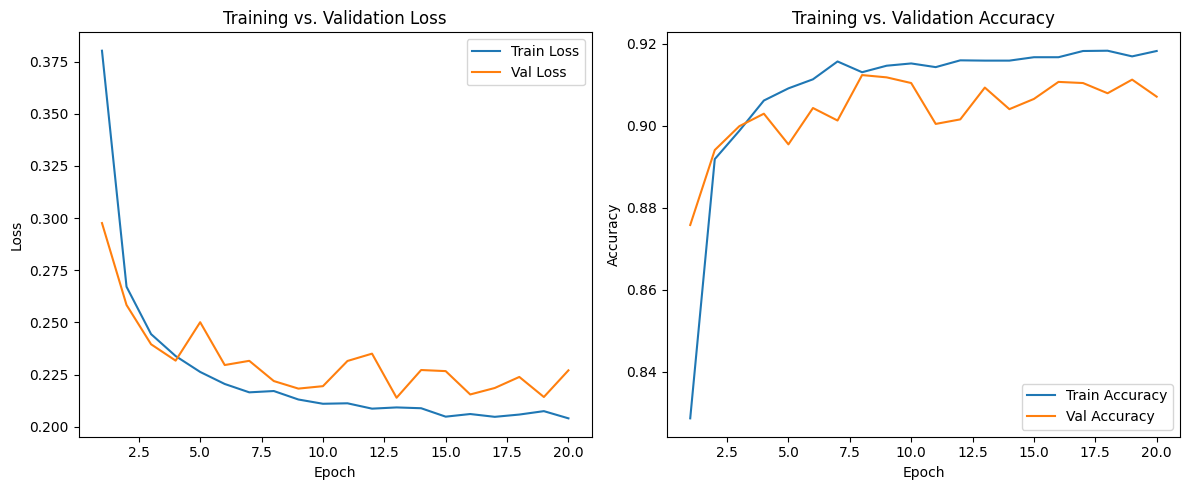

In [14]:
## Training and testing loop

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training parameters
num_epochs = 20             # Number of epochs (adjust as needed)
learning_rate = 0.001       # Learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_deit.head.parameters(), lr=learning_rate)

# Lists to track metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1_scores = []

# Training loop
for epoch in range(num_epochs):
    # === Training Phase ===
    model_deit.head.train()
    running_loss, correct_preds, total = 0.0, 0, 0

    for features, labels in precomputed_train_loader:
        features, labels = features.to(device), labels.to(device)
        # Select the CLS token (first token) for classification
        cls_features = features[:, 0, :]

        optimizer.zero_grad()
        outputs = model_deit.head(cls_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct_preds += torch.sum(preds == labels).item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct_preds / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # === Validation Phase ===
    model_deit.head.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    all_val_preds, all_val_labels = [], []

    with torch.no_grad():
        for features, labels in precomputed_val_loader:
            features, labels = features.to(device), labels.to(device)
            cls_features = features[:, 0, :]
            outputs = model_deit.head(cls_features)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_correct += torch.sum(preds == labels).item()
            val_total += labels.size(0)

            all_val_preds.append(preds.cpu())
            all_val_labels.append(labels.cpu())

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Compute the F1-score on the validation set (binary average for 2 classes)
    all_val_preds = torch.cat(all_val_preds).numpy()
    all_val_labels = torch.cat(all_val_labels).numpy()
    val_f1 = f1_score(all_val_labels, all_val_preds, average="binary")
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%} | Val F1: {val_f1:.4f}")

print("✅ Training completed!")



# === Final Evaluation on the Test Set ===
model_deit.head.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for features, labels in precomputed_test_loader:
        features, labels = features.to(device), labels.to(device)
        cls_features = features[:, 0, :]
        outputs = model_deit.head(cls_features)
        preds = torch.argmax(outputs, dim=1)
        all_test_preds.append(preds.cpu())
        all_test_labels.append(labels.cpu())

all_test_preds = torch.cat(all_test_preds).numpy()
all_test_labels = torch.cat(all_test_labels).numpy()

# Display the confusion matrix
cm = confusion_matrix(all_test_labels, all_test_preds)
print("Confusion matrix on the test set:")
print(cm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Test Confusion Matrix")
plt.xlabel("Predictions")
plt.ylabel("Truth")
plt.show()

# Display the classification report
print("Classification report on the test set:")
report_str = classification_report(all_test_labels, all_test_preds, target_names=["Normal", "COVID-19"])

# Create a figure to display the text
plt.figure(figsize=(10, 6))
plt.text(0.01, 0.05, report_str, {'fontsize': 10}, fontfamily='monospace')
plt.axis('off')
plt.title("Classification Report")
plt.tight_layout()
plt.show()

# === Plotting Loss and Accuracy Curves ===
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("loss_accuracy_curves.png")
plt.show()


We finally want to save the weights of the head.

In [15]:
from google.colab import files

# Save the model's head weights to a temporary file
temp_save_path = "deit_tiny_head_weights.pth"
torch.save(model_deit.head.state_dict(), temp_save_path)

# Download the file to your local computer
files.download(temp_save_path)
files.download("loss_accuracy_curves.png")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>